In [1]:
from src.utils.extract_utils import gather_activations, gather_activations_from_dataset

/root/activation-additions-large-models/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch, transformers, accelerate, einops

In [3]:
from src.utils.model_utils import load_gpt_model_and_tokeniser

In [4]:
model, tokenizer, MODEL_CONFIG = load_gpt_model_and_tokeniser(model_name="meta-llama/Llama-2-13b-hf")

Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]
/root/activation-additions-large-models/myenv/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [5]:
from src.utils.describe_utils import average_cosine_sim

# Get Datasets

In [6]:
from datasets import load_dataset

training_dataset = load_dataset("Skylion007/openwebtext", streaming=True)

shuffled_training_dataset = training_dataset.shuffle(seed=21)

In [7]:
subset = shuffled_training_dataset["train"].take(1000)

In [8]:
texts = []

for example in subset:
    # Use the first 200 tokens
    texts.append(tokenizer.decode(tokenizer.encode(example["text"])[:100]))


In [10]:
texts[:20]

['<s> Media playback is unsupported on your device Media caption The BBC\'s Christian Fraser on the "front line" in East Jerusalem\n\nIsraeli leaders have appealed for calm after the discovery of a kidnapped Palestinian teenager\'s body sparked clashes in East Jerusalem.\n\nMohammed Abu Khdair, 17, was seen being forced into a car early on Wednesday.\n\nIsraeli',
 '<s> 1 of 8 Full Screen Autoplay Close Skip Ad × The fall and rise of shorts in the NBA View Photos After years of long, baggy shorts forming the template for basketball uniforms, a new generation of players is willing to show more leg. Caption After years of long, baggy shorts forming the template for basketball uniforms, a new generation of players is willing to show more leg. Washington Wizards rookie Kelly Oubre Jr',
 '<s> Kevin Love decided to take a casual weekend trip to Boston, much to the delight of Boston Celtics fans everywhere.\n\nThe Minnesota Timberwolves forward is rumored to be a target of the rebuilding Celti

# Cosine Sim Experiment


In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
!nvidia-smi

Sat Dec  2 04:44:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


|   0  Quadro RTX 6000                On  | 00000000:3E:00.0 Off |                  Off |
| 33%   45C    P8              30W / 260W |  19873MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000                On  | 00000000:3F:00.0 Off |                  Off |
| 33%   39C    P8              25W / 260W |  19873MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   G

In [9]:
torch.no_grad()

In [11]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

Gathering activations: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


{'attn_hook_names': {0: 0.7502409815788269, 1: 0.25621670484542847, 2: 0.1648905873298645, 3: 0.23579882085323334, 4: 0.17759352922439575, 5: 0.1513374298810959, 6: 0.09256576746702194, 7: 0.0746467113494873, 8: 0.06608642637729645, 9: 0.10343392193317413, 10: 0.04844335839152336, 11: 0.045546043664216995, 12: 0.05624251812696457, 13: 0.049515578895807266, 14: 0.04775175079703331, 15: 0.03802862763404846, 16: 0.03132333606481552, 17: 0.043452564626932144, 18: 0.03814318776130676, 19: 0.050987426191568375, 20: 0.04919261112809181, 21: 0.04790457338094711, 22: 0.0668550431728363, 23: 0.09352587908506393, 24: 0.08198695629835129, 25: 0.06565488874912262, 26: 0.11204715818166733, 27: 0.08527898788452148, 28: 0.2564253807067871, 29: 0.058139868080616, 30: 0.0912974551320076, 31: 0.05163293331861496, 32: 0.05940411239862442, 33: 0.12796524167060852, 34: 0.06093887239694595, 35: 0.09627265483140945, 36: 0.22360365092754364, 37: 0.568882167339325, 38: 0.3938654661178589, 39: 0.3452605009078979

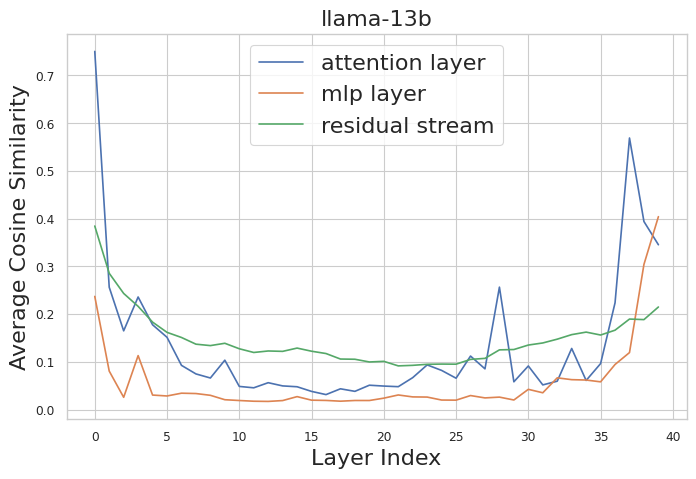

In [11]:
activation_storage = average_cosine_sim(
    texts[:50],
    ["attn_hook_names", "mlp_hook_names", "layer_hook_names"],
    model,
    tokenizer,
    MODEL_CONFIG,
    len(texts[:50]),
    False,
    False,
    False
)

# Trying for new models!

## GPT-J-6B

In [7]:
model, tokenizer, MODEL_CONFIG = load_gpt_model_and_tokeniser(model_name="EleutherAI/gpt-j-6B")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Gathering activations: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


{'attn_hook_names': {0: 0.25947079062461853, 1: 0.27140045166015625, 2: 0.10957791656255722, 3: 0.11392711848020554, 4: 0.15194940567016602, 5: 0.11435126513242722, 6: 0.09559398889541626, 7: 0.11489040404558182, 8: 0.07147042453289032, 9: 0.09177291393280029, 10: 0.09053095430135727, 11: 0.11047456413507462, 12: 0.06775402277708054, 13: 0.10770273953676224, 14: 0.1307845562696457, 15: 0.11520815640687943, 16: 0.07851947844028473, 17: 0.06475929915904999, 18: 0.07729467004537582, 19: 0.09138844162225723, 20: 0.12151429802179337, 21: 0.046258922666311264, 22: 0.0843602865934372, 23: 0.07991037517786026, 24: 0.07347824424505234, 25: 0.06931690126657486, 26: 0.11505940556526184, 27: 0.09637095779180527}, 'layer_hook_names': {0: 0.8372409343719482, 1: 0.7875101566314697, 2: 0.6718604564666748, 3: 0.6133042573928833, 4: 0.6388245224952698, 5: 0.571786642074585, 6: 0.5796570181846619, 7: 0.5254808664321899, 8: 0.5106713175773621, 9: 0.48524221777915955, 10: 0.4760209023952484, 11: 0.45075011

FileNotFoundError: [Errno 2] No such file or directory: 'results/cosine-sims/EleutherAI/gpt-j-6B-07-11-2023_18-34-46.pdf'

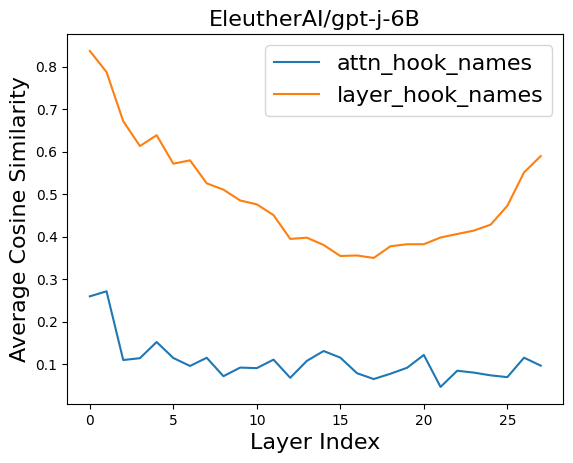

In [12]:
activation_storage = average_cosine_sim(
    texts[:30],
    ["attn_hook_names", "layer_hook_names"],
    model,
    tokenizer,
    MODEL_CONFIG,
    len(texts[:30]),
    False,
    True,
    False
)

In [23]:
texts[1]

"Well, that didn't take long. TeamWin has just dropped a new version of its TWRP custom recovery designed specifically for the Flo – the new Nexus 7. As usual, it's a fairly simple procedure with a Nexus device to get a custom recovery running, which allows you to flash root. The Android 4.3 SuperSU file is already out there, so we're ready to go.\n\nDisclaimer: Android Police isn't responsible for any harm to your device - proceed at your own risk. : Android Police isn't responsible for any harm to your device - proceed at your own risk.\n\nFirst, grab the TWRP image from the TeamWin site. Then get the SuperSU zip file right over here. Put the SuperSU file on the Nexus 7's internal storage, and move the TWRP image to the folder where you have ADB and fastboot. Before you get started, make sure your bootloader is unlocked (fastboot oem unlock). Then do the following:\n\nFlash TWRP from the bootloader (fastboot flash recovery FILENAME.img). You can try using boot instead of flash, but i

## GPT-Neox

In [9]:
!nvidia-smi

Tue Nov  7 18:57:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:B1:00.0 Off |                  Off |
| 30%   37C    P2              70W / 300W |  39664MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
model, tokenizer, MODEL_CONFIG = load_gpt_model_and_tokeniser(model_name="EleutherAI/gpt-neox-20b")

Loading checkpoint shards: 100%|██████████| 46/46 [00:08<00:00,  5.36it/s]


In [14]:
activation_storage = average_cosine_sim(
    texts[:30],
    ["attn_hook_names", "layer_hook_names"],
    model,
    tokenizer,
    MODEL_CONFIG,
    len(texts[:30]),
    False,
    True,
    False
)

Gathering activations:   0%|          | 0/29 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)

## Llama2 7B

In [15]:
torch.device('cpu')

device(type='cpu')

In [ ]:
model, tokenizer, MODEL_CONFIG = load_gpt_model_and_tokeniser(model_name="meta-llama/Llama-2-7b-hf")

In [ ]:
activation_storage = average_cosine_sim(
    texts[:30],
    ["attn_hook_names", "layer_hook_names"],
    model,
    tokenizer,
    MODEL_CONFIG,
    len(texts[:30]),
    False,
    True,
    False
)

## Llama2 13B

In [ ]:
model, tokenizer, MODEL_CONFIG = load_gpt_model_and_tokeniser(model_name="meta-llama/Llama-2-13b-hf")

In [ ]:
activation_storage = average_cosine_sim(
    texts[:30],
    ["attn_hook_names", "layer_hook_names"],
    model,
    tokenizer,
    MODEL_CONFIG,
    len(texts[:30]),
    False,
    True,
    False
)

In [19]:
activation_storage['attn_hook_names'][2]

tensor([[[-5.8923e-03,  6.4311e-03,  6.6518e-02,  ..., -1.1169e-02,
           5.4242e-02,  3.5208e-02]],

        [[-1.6433e-01, -2.0460e-01, -1.8544e-01,  ..., -9.3142e-02,
          -1.1714e-01,  7.2037e-02]],

        [[-4.8122e-02, -7.1874e-03, -2.9214e-02,  ..., -1.4442e-01,
           4.1209e-02, -1.0184e-02]],

        ...,

        [[-1.5061e+00, -8.8653e-01, -1.1606e+00,  ..., -3.4726e+01,
          -3.4099e+00, -1.6399e+00]],

        [[-2.0221e+00, -1.2480e+00, -1.9758e+00,  ..., -6.3210e+01,
          -1.0448e+00, -1.5415e+00]],

        [[-4.8610e-01,  1.1211e+00,  1.2636e-01,  ..., -8.3026e+00,
          -2.3063e-02, -4.6300e-02]]])

In [13]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  47900 MiB |  47910 MiB |  97208 MiB |  49308 MiB |\n|       from large pool |  46917 MiB |  46926 MiB |  90860 MiB |  43943 MiB |\n|       from small pool |    983 MiB |   1033 MiB |   6348 MiB |   5364 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  47900 MiB |  47910 MiB |  97208 MiB |  49308 MiB |\n|       from large pool |  46917 MiB |  46926 MiB |

In [6]:
activations = gather_activations_from_dataset(
    ["Good day sir, how are you doing today?"]*30,
    ["attn_hook_names"],
    model,
    tokenizer,
    MODEL_CONFIG,
    20,
    False,
    True
)


Gathering activations: 100%|██████████| 20/20 [00:01<00:00, 11.70it/s]


In [7]:
X = torch.concatenate([activations["attn_hook_names"][i][23] for i in range(20)])

In [8]:
X.shape

torch.Size([20, 1600])

In [9]:
X.norm(dim=1)

tensor([11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168,
        11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168,
        11.0168, 11.0168, 11.0168, 11.0168], device='cuda:0',
       grad_fn=<LinalgVectorNormBackward0>)

In [10]:
normed_X = X / X.norm(dim=1)[:, None]

In [11]:
normed_X.shape

torch.Size([20, 1600])

In [13]:
sim = torch.mm(normed_X, normed_X.t())    

In [15]:
sim.shape

torch.Size([20, 20])

In [16]:
# Get the upper triangle (only want to compute each pair once)
sim_values = sim[torch.triu(torch.ones_like(sim), diagonal=1) == 1]

In [17]:
sim_values

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [19]:
model._name_

AttributeError: 'GPT2LMHeadModel' object has no attribute '_name_'